0. Prerequisites

In [20]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from PIL import Image
import nltk
from transformers import pipeline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import torch

1. Data Cleaning & Preprocessing

In [21]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Read the text file
with open('Lord_of_The_Rings.txt', 'r', encoding='utf-8', errors='ignore') as file:
    text = file.read()

# Identify books and chapters using regular expressions
books = re.split(r'BOOK [IVXLCDM]+', text)
books = [book.strip() for book in books if book.strip()]

structured_data = []
for book_num, book in enumerate(books, start=1):
    chapters = re.split(r'Chapter \d+', book)
    chapters = [chapter.strip() for chapter in chapters if chapter.strip()]
    # Debugging: Print the chapters list to see if there are any extra empty strings
    # print(f"Book {book_num} chapters:", chapters)
    for chapter_num, chapter in enumerate(chapters, start=0):
        structured_data.append((f'BOOK {book_num}', f'Chapter {chapter_num}', chapter))

# Create a DataFrame with structured data
df = pd.DataFrame(structured_data, columns=['Book', 'Chapter', 'Text'])

# NLTK stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalpha() and word.lower() not in stop_words]
    return words

# Apply the cleaning function to the text in the DataFrame
df['Cleaned_Text'] = df['Text'].apply(clean_text)

# Explode the cleaned text into individual words
exploded_df = df.explode('Cleaned_Text')

# Rename the exploded column for clarity
exploded_df = exploded_df.rename(columns={'Cleaned_Text': 'Word'})

# Select relevant columns
final_df = exploded_df[['Book', 'Chapter', 'Word']]

# Remove NaN values
final_df = final_df.dropna()

# Reset the index
final_df = final_df.reset_index(drop=True)

# Save to a CSV file (optional)
final_df.to_csv('Lord_of_the_Rings_Words.csv', index=False)

# Display the final DataFrame
print(final_df.head())


[nltk_data] Downloading package punkt to /home/fericf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/fericf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/fericf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     Book    Chapter     Word
0  BOOK 1  Chapter 1    party
1  BOOK 1  Chapter 1    bilbo
2  BOOK 1  Chapter 1  baggins
3  BOOK 1  Chapter 1      bag
4  BOOK 1  Chapter 1      end


2. Sentiment Analysis

2.1 VADER Model

In [22]:
# Download necessary NLTK data
nltk.download('vader_lexicon')

# Sentiment analysis setup
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = sid.polarity_scores(text)
    return scores['compound']

# Apply sentiment analysis to each chapter
df['Sentiment'] = df['Text'].apply(get_sentiment)

# Calculate overall sentiment
overall_sentiment = sid.polarity_scores(' '.join(df['Text']))['compound']

# Save sentiment data to a CSV file (optional)
df[['Book', 'Chapter', 'Sentiment']].to_csv('Lord_of_the_Rings_Sentiment.csv', index=False)

# Print the sentiment for each chapter
print(df[['Book', 'Chapter', 'Sentiment']].head(10))

# Print the overall sentiment of the text
print(f"Overall Sentiment of the Text: {overall_sentiment}")

#Conclusion this model is not suitable for our data. We have to use a transformer.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/fericf/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


     Book    Chapter  Sentiment
0  BOOK 1  Chapter 0     0.0000
1  BOOK 1  Chapter 1     1.0000
2  BOOK 1  Chapter 2     0.9999
3  BOOK 1  Chapter 3     0.9999
4  BOOK 1  Chapter 4     0.9983
5  BOOK 1  Chapter 5     0.9999
6  BOOK 1  Chapter 6     0.9991
7  BOOK 1  Chapter 7     0.9999
8  BOOK 1  Chapter 8     0.9998
9  BOOK 1  Chapter 9     0.9997
Overall Sentiment of the Text: 1.0


2.2 Transformer from Huggin Face

In [23]:
# Initialize the sentiment analysis pipeline with GPU
device = 0 if torch.cuda.is_available() else -1
sentiment_pipeline = pipeline("sentiment-analysis", device=device)

def get_sentiment(text):
    # Split text into chunks of max 512 tokens
    max_length = 256
    tokens = text.split()
    chunks = [' '.join(tokens[i:i + max_length]) for i in range(0, len(tokens), max_length)]
    
    sentiments = []
    for chunk in chunks:
        result = sentiment_pipeline(chunk)[0]
        sentiments.append(1 if result['label'] == 'POSITIVE' else -1)
    
    # Return the average sentiment of the chunks
    return np.mean(sentiments)

# Apply sentiment analysis to each chapter
df['Sentiment'] = df['Text'].apply(get_sentiment)

# Calculate overall sentiment
overall_sentiment = get_sentiment(' '.join(df['Text']))

# Save sentiment data to a CSV file (optional)
df[['Book', 'Chapter', 'Sentiment']].to_csv('Lord_of_the_Rings_Sentiment.csv', index=False)

# Print the sentiment for each chapter
print(df[['Book', 'Chapter', 'Sentiment']].head())

# Print the overall sentiment of the text
print(f"Overall Sentiment of the Text: {overall_sentiment}")

# Convert sentiment values to numeric values
df['sentiment_value'] = df['Sentiment']

# Extract numeric part of 'Chapter' and convert to integers for sorting
df['Chapter'] = df['Chapter'].str.extract('(\d+)').astype(int)

# Filter out chapters labeled as 0 and sort by chapters
df = df[df['Chapter'] != 0]
df = df.sort_values(by='Chapter')

# Calculate the average sentiment per chapter
avg_sentiment_per_chapter = df.groupby(['Book', 'Chapter'])['sentiment_value'].mean().reset_index()

# Calculate the average sentiment per book
avg_sentiment_per_book = df.groupby('Book')['sentiment_value'].mean().reset_index()

<>:38: SyntaxWarning:

invalid escape sequence '\d'

<>:38: SyntaxWarning:

invalid escape sequence '\d'

/tmp/ipykernel_22757/663783586.py:38: SyntaxWarning:

invalid escape sequence '\d'

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


     Book    Chapter  Sentiment
0  BOOK 1  Chapter 0   1.000000
1  BOOK 1  Chapter 1  -0.128205
2  BOOK 1  Chapter 2  -0.363636
3  BOOK 1  Chapter 3  -0.631579
4  BOOK 1  Chapter 4  -0.391304
Overall Sentiment of the Text: -0.3770491803278688


2.3 Creating the visualization of the data

In [24]:
# Create separate plots for each book
figs = []

for book in df['Book'].unique():
    book_data = avg_sentiment_per_chapter[avg_sentiment_per_chapter['Book'] == book]
    fig = go.Figure()
    fig.add_trace(go.Bar(x=book_data['Chapter'], y=book_data['sentiment_value'], name=f'{book} Sentiment per Chapter'))
    fig.update_layout(title=f'Sentiment Analysis - {book}', xaxis_title='Chapter', yaxis_title='Sentiment')
    figs.append(fig)

# Subplot 2: Average sentiment per book
fig_avg_sentiment = go.Figure(go.Bar(x=avg_sentiment_per_book['Book'], y=avg_sentiment_per_book['sentiment_value'], name='Average Sentiment per Book'))
fig_avg_sentiment.update_layout(title='Average Sentiment per Book', xaxis_title='Book', yaxis_title='Average Sentiment')

# Subplot 3: Overall mean sentiment
fig_overall_sentiment = go.Figure(go.Indicator(mode="number", value=overall_sentiment, title={"text": "The overall sentiment of the series is:"}))
fig_overall_sentiment.update_layout(title='Overall Mean Sentiment')

# Display the figures
for i, fig in enumerate(figs):
    fig.show()
fig_avg_sentiment.show()
fig_overall_sentiment.show()

3.0 N-Grams and their occurances

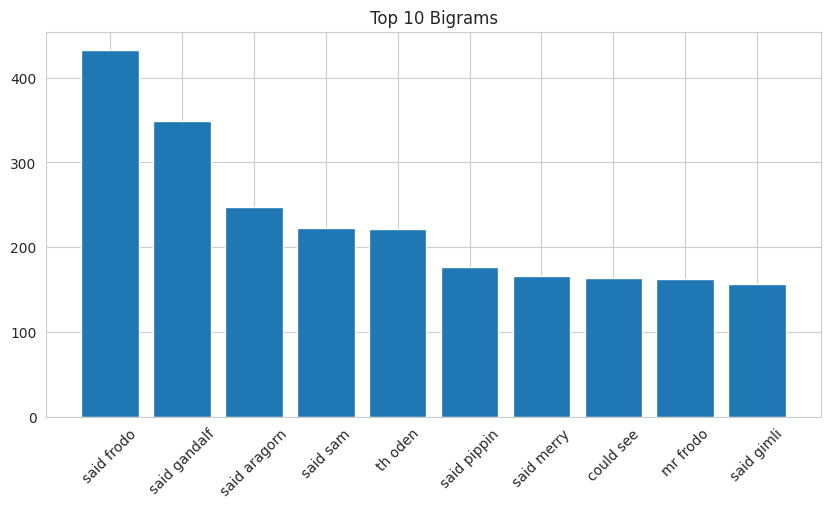

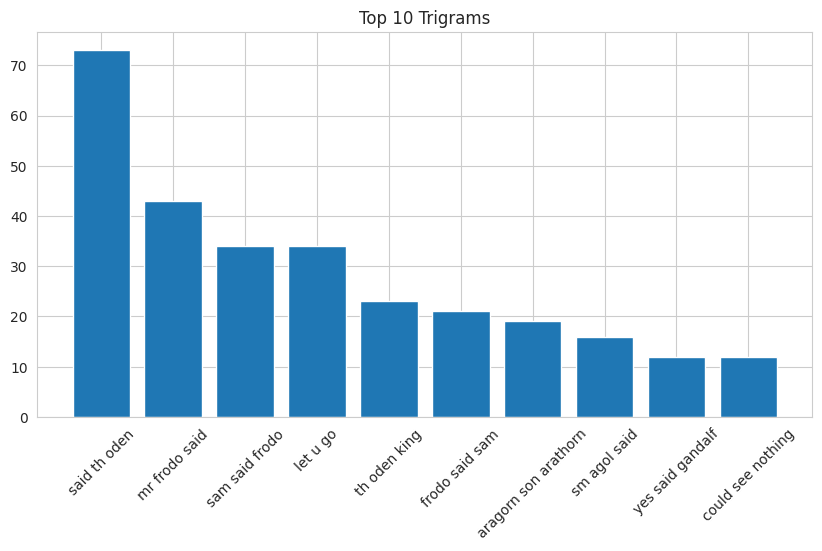

Top 10 Bigrams: [('said frodo', 433), ('said gandalf', 349), ('said aragorn', 247), ('said sam', 223), ('th oden', 222), ('said pippin', 176), ('said merry', 166), ('could see', 163), ('mr frodo', 162), ('said gimli', 157)]
Top 10 Trigrams: [('said th oden', 73), ('mr frodo said', 43), ('sam said frodo', 34), ('let u go', 34), ('th oden king', 23), ('frodo said sam', 21), ('aragorn son arathorn', 19), ('sm agol said', 16), ('yes said gandalf', 12), ('could see nothing', 12)]


In [25]:
# Preprocess text data
def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

df['Processed_Text'] = df['Text'].apply(preprocess)

# 1. TF-IDF Implementation
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Processed_Text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# 3. N-grams
def generate_ngrams(text, n):
    tokens = word_tokenize(text)
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

# Generate bigrams and trigrams
df['Bigrams'] = df['Processed_Text'].apply(lambda text: generate_ngrams(text, 2))
df['Trigrams'] = df['Processed_Text'].apply(lambda text: generate_ngrams(text, 3))

# Analyze the most common n-grams
bigrams = Counter([bigram for sublist in df['Bigrams'] for bigram in sublist])
trigrams = Counter([trigram for sublist in df['Trigrams'] for trigram in sublist])

# Plot the most common bigrams and trigrams
def plot_ngrams(ngrams_counter, title):
    common_ngrams = ngrams_counter.most_common(10)
    ngrams, counts = zip(*common_ngrams)
    plt.figure(figsize=(10, 5))
    plt.bar(ngrams, counts)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_ngrams(bigrams, 'Top 10 Bigrams')
plot_ngrams(trigrams, 'Top 10 Trigrams')

# Insights
print("Top 10 Bigrams:", bigrams.most_common(10))
print("Top 10 Trigrams:", trigrams.most_common(10))

4.0 Calculate the word frequency and extract the top 50 words

In [26]:
# Calculate word frequencies
word_freq = Counter(final_df['Word'])

# Select top 50 words (adjust the number as needed)
top_words = word_freq.most_common(50)
top_words = dict(top_words)  # Convert to dictionary for wordcloud input

4.1 Wordcloud with the most common words

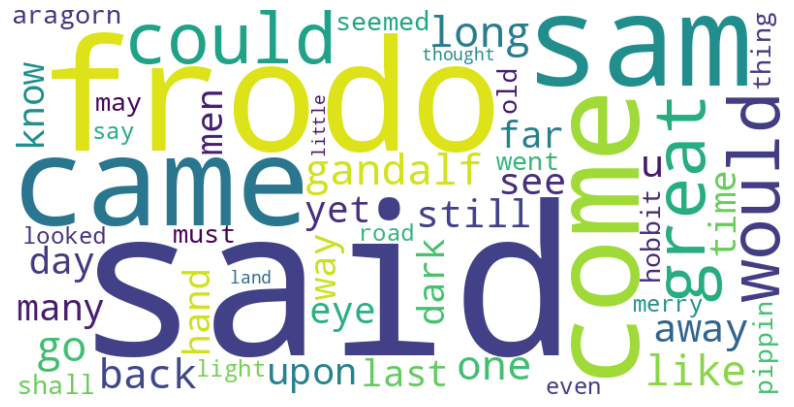

In [27]:
# Generate wordcloud
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)

# Plot the wordcloud
plt.figure(figsize=(10, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

        5.0 Part of Speech recogniziton

5.1 Creating the PoS DataFrame

In [28]:
# Ensure the required NLTK resources are downloaded
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

# Tokenize the text
tokens = nltk.word_tokenize(df['Text'].str.cat(sep=' '))

# Perform PoS tagging
pos_tags = nltk.pos_tag(tokens, tagset='universal')

# Convert PoS tags to a DataFrame
final_df_pos = pd.DataFrame(pos_tags, columns=['Word', 'PoS'])
display(final_df_pos)

[nltk_data] Downloading package punkt to /home/fericf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/fericf/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/fericf/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


,Word,PoS
0,_,VERB
1,A,DET
2,Long-expected,NOUN
3,Party,NOUN
4,When,ADV
...,...,...
555813,and,CONJ
555814,saw,VERB
555815,no,DET
555816,more,ADV


5.2 Advanced Plotting Using Seaborn

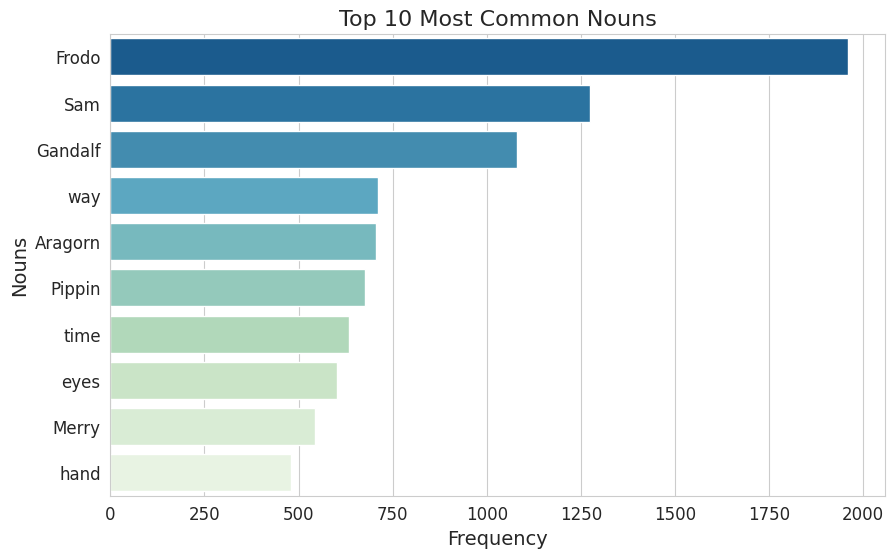

In [29]:
# Filter DataFrame for rows where PoS is 'NOUN'
nouns_df = final_df_pos[final_df_pos['PoS'] == 'NOUN']

# Count the occurrences of each noun, find top 10
noun_counts = nouns_df['Word'].value_counts()
top_10_nouns = noun_counts.head(10)

# Convert the Series to DataFrame for seaborn
top_10_nouns_df = top_10_nouns.reset_index()
top_10_nouns_df.columns = ['Nouns', 'Frequency']

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Nouns', data=top_10_nouns_df, palette="GnBu_r", hue='Nouns')

# Add titles and labels
plt.title('Top 10 Most Common Nouns', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Nouns', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


5.3 Multi-PoS Plot

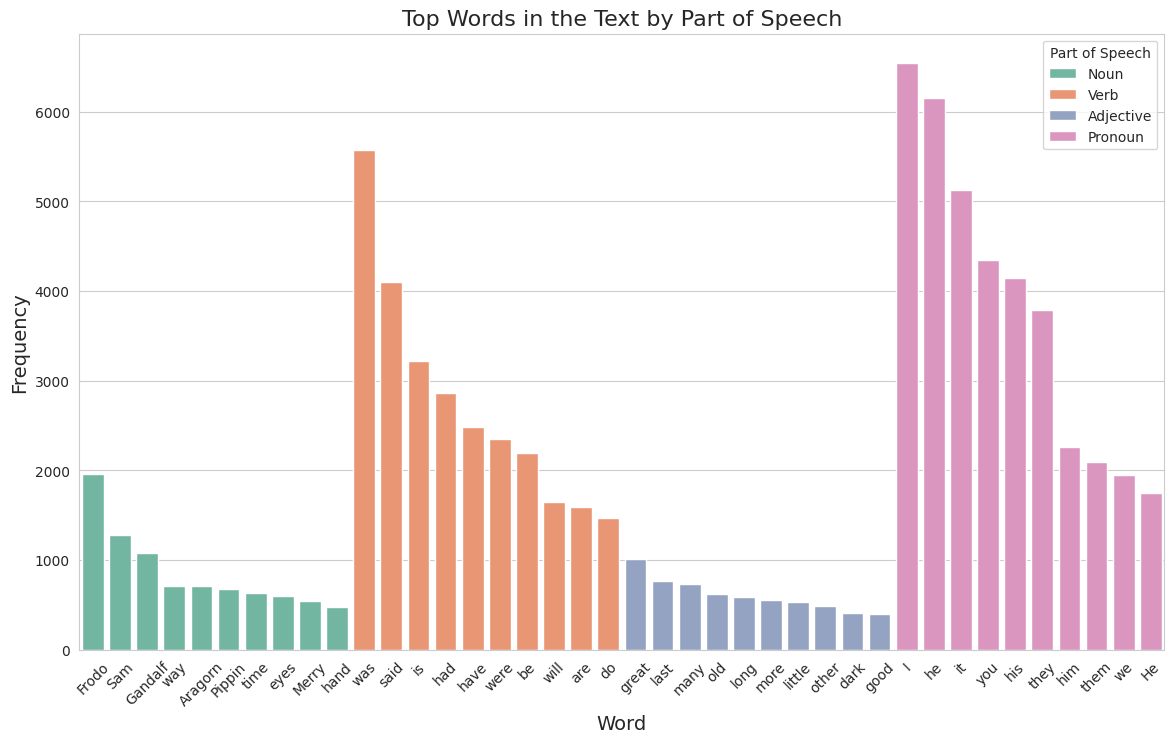

In [30]:
# Count occurrences of each PoS and find top 10
noun_counts = final_df_pos[final_df_pos['PoS'] == 'NOUN']['Word'].value_counts().head(10)
verb_counts = final_df_pos[final_df_pos['PoS'] == 'VERB']['Word'].value_counts().head(10)
adj_counts = final_df_pos[final_df_pos['PoS'] == 'ADJ']['Word'].value_counts().head(10)
pronoun_counts = final_df_pos[final_df_pos['PoS'] == 'PRON']['Word'].value_counts().head(10)

# Combine the top words into a single DataFrame
top_words_combined = pd.concat([
    noun_counts.rename('Frequency').reset_index().assign(PoS='Noun'),
    verb_counts.rename('Frequency').reset_index().assign(PoS='Verb'),
    adj_counts.rename('Frequency').reset_index().assign(PoS='Adjective'),
    pronoun_counts.rename('Frequency').reset_index().assign(PoS='Pronoun')
])

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Word', y='Frequency', hue='PoS', data=top_words_combined, palette='Set2')
plt.title('Top Words in the Text by Part of Speech', fontsize=16)
plt.xlabel('Word', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Part of Speech')
plt.show()


5.4 Frequency-Sorted Multi-PoS Plot


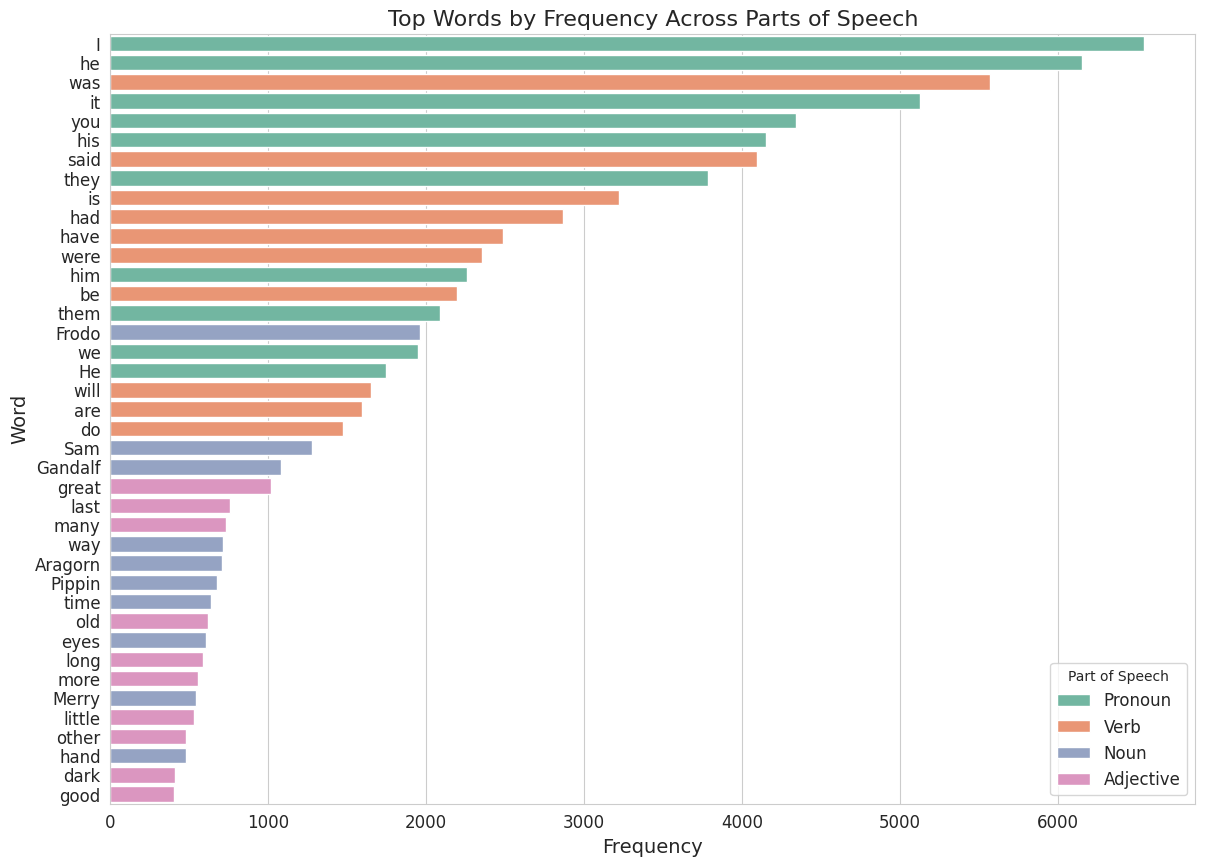

In [31]:
# Sort the DataFrame by 'Frequency' in descending order
top_words_sorted = top_words_combined.sort_values(by='Frequency', ascending=False)

# Plot with sorted values
plt.figure(figsize=(14, 10))
sns.barplot(y='Word', x='Frequency', hue='PoS', data=top_words_sorted, palette='Set2', dodge=False)
plt.title('Top Words by Frequency Across Parts of Speech', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Word', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Part of Speech', fontsize=12)
plt.show()

6.0 Wordclouds using PoS for the main characters

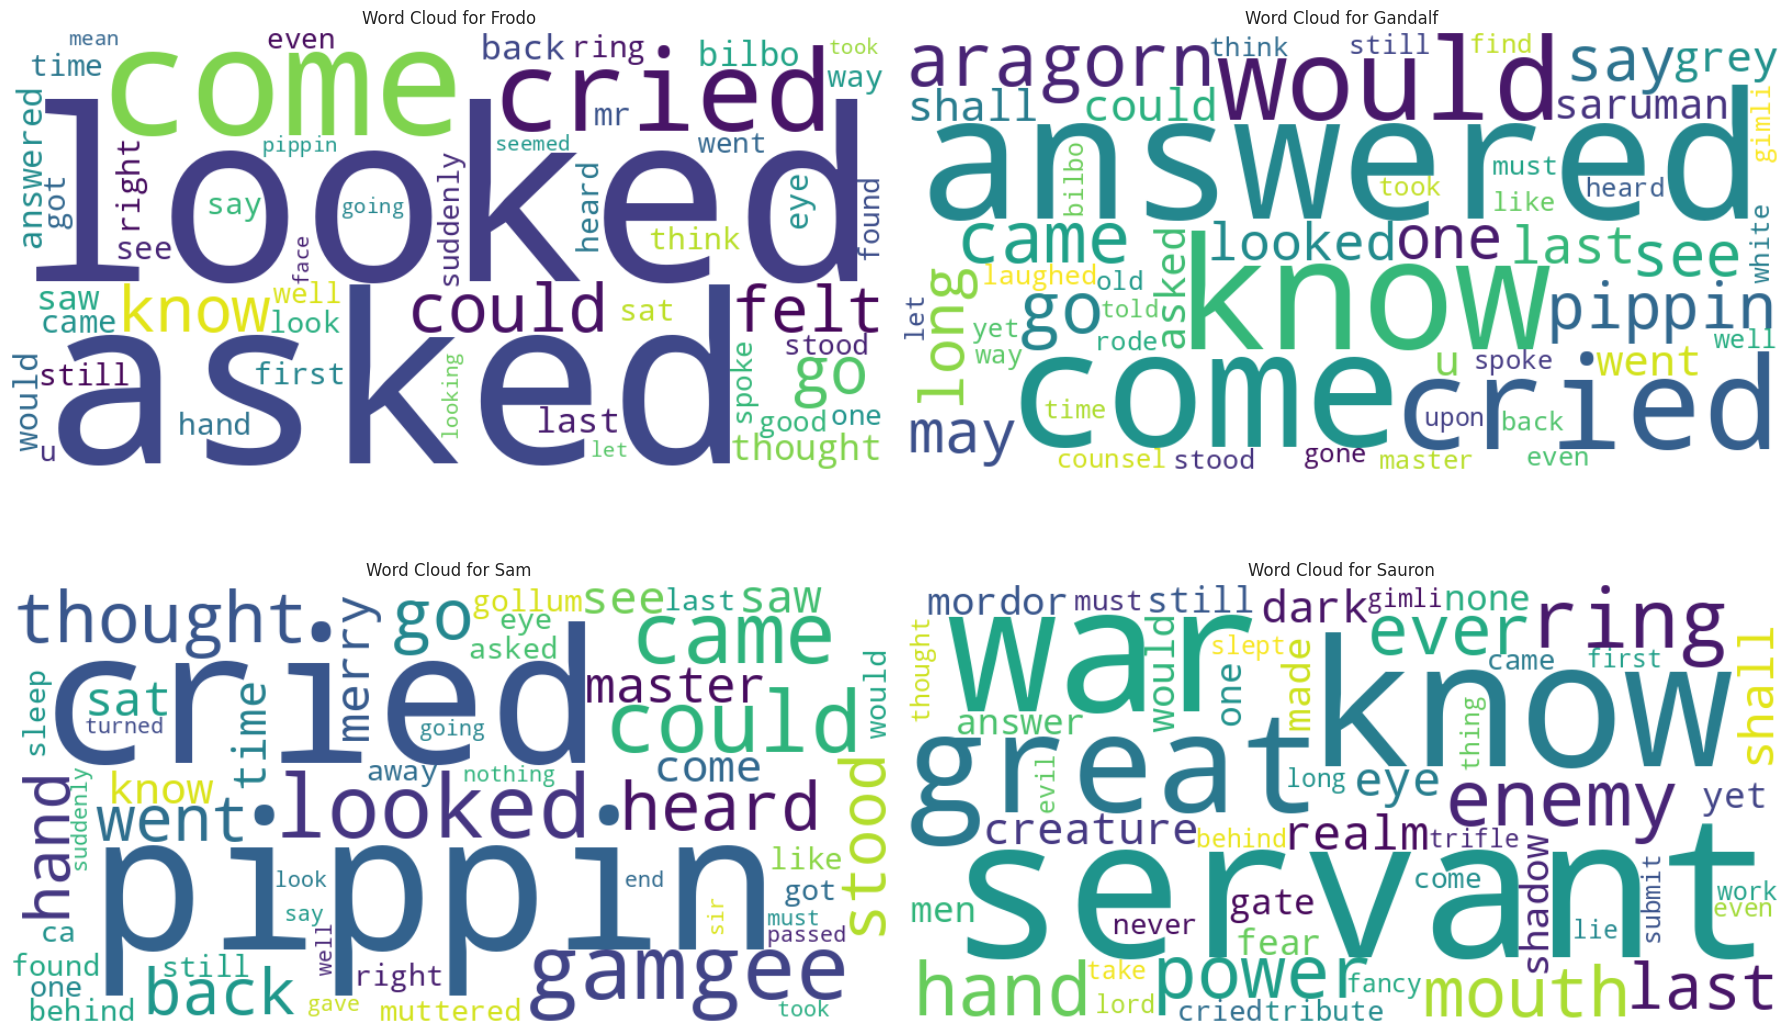

In [32]:
# Overwrite the clean_text function to meet our needs
def clean_text(text):
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalpha() and word.lower() not in stop_words and word.lower() != 'said']
    return ' '.join(words)

# Apply the cleaning function to the text in the DataFrame
df['Processed_Text'] = df['Text'].apply(clean_text)

# Generate bigrams and trigrams
def generate_ngrams(text, n):
    tokens = word_tokenize(text)
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

df['Bigrams'] = df['Processed_Text'].apply(lambda text: generate_ngrams(text, 2))
df['Trigrams'] = df['Processed_Text'].apply(lambda text: generate_ngrams(text, 3))

# Function to perform PoS tagging and filter verbs and nouns, excluding specified words
def filter_verbs_nouns(text, exclude_words=[]):
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens, tagset='universal')
    filtered_words = [word for word, pos in pos_tags if pos in ['NOUN', 'VERB', 'ADJ'] and word not in exclude_words]
    return ' '.join(filtered_words)

# Apply PoS tagging and filtering to the processed text
df['Filtered_Text'] = df['Processed_Text'].apply(filter_verbs_nouns)

# Flatten the filtered text into words
filtered_words = ' '.join(df['Filtered_Text']).split()

# Calculate word frequencies for filtered words
word_freq = Counter(filtered_words)

# Define function to filter n-grams containing specific words, excluding specified words
def filter_ngrams_by_word(ngrams_series, word, exclude_words=[]):
    filtered_ngrams = []
    for ngrams_list in ngrams_series:
        for ngram in ngrams_list:
            ngram_words = ngram.lower().split()
            if word in ngram_words and all(exclude_word not in ngram_words for exclude_word in exclude_words):
                filtered_ngrams.append(ngram)
    return filtered_ngrams

# Filter n-grams for each character and generate word clouds
frodo_ngrams = filter_ngrams_by_word(df['Trigrams'], 'frodo')
gandalf_ngrams = filter_ngrams_by_word(df['Trigrams'], 'gandalf')
sam_ngrams = filter_ngrams_by_word(df['Trigrams'], 'sam')
sauron_ngrams = filter_ngrams_by_word(df['Trigrams'], 'sauron')

# Flatten the filtered n-grams
def flatten_ngrams(ngrams_list):
    words = []
    for ngram in ngrams_list:
        words.extend(ngram.split())
    return words

frodo_words = flatten_ngrams(frodo_ngrams)
gandalf_words = flatten_ngrams(gandalf_ngrams)
sam_words = flatten_ngrams(sam_ngrams)
sauron_words = flatten_ngrams(sauron_ngrams)

# Remove character names from the words list
character_names = ['frodo', 'gandalf', 'sam', 'sauron']
frodo_words = [word for word in frodo_words if word not in character_names]
gandalf_words = [word for word in gandalf_words if word not in character_names]
sam_words = [word for word in sam_words if word not in character_names]
sauron_words = [word for word in sauron_words if word not in character_names]

# Calculate word frequencies for each
word_freq_frodo = Counter(frodo_words)
word_freq_gandalf = Counter(gandalf_words)
word_freq_sam = Counter(sam_words)
word_freq_sauron = Counter(sauron_words)

# Select top 50 words for each
top_words_frodo = word_freq_frodo.most_common(50)
top_words_gandalf = word_freq_gandalf.most_common(50)
top_words_sam = word_freq_sam.most_common(50)
top_words_sauron = word_freq_sauron.most_common(50)

# Convert to dictionary for wordcloud input
top_words_dict_frodo = dict(top_words_frodo)
top_words_dict_gandalf = dict(top_words_gandalf)
top_words_dict_sam = dict(top_words_sam)
top_words_dict_sauron = dict(top_words_sauron)

# Generate word clouds for each character
wc_frodo = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_dict_frodo)
wc_gandalf = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_dict_gandalf)
wc_sam = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_dict_sam)
wc_sauron = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_dict_sauron)

# Plot the word clouds grouped into two groups
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.imshow(wc_frodo, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Frodo')

plt.subplot(2, 2, 2)
plt.imshow(wc_gandalf, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Gandalf')

plt.subplot(2, 2, 3)
plt.imshow(wc_sam, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Sam')

plt.subplot(2, 2, 4)
plt.imshow(wc_sauron, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Sauron')

plt.tight_layout()
plt.show()
